The data generating process can be describled as
\begin{equation*}
Y_{it} = (X_{it}\Gamma) F_{t} + \epsilon_{it}.
\end{equation*}

The derivation of the GSC-IPCA estimator from the minimization problem:

\begin{equation*}
(\hat{\Gamma}, \hat{F}_t) = \underset{\Gamma, F_t}{\arg\min} \sum_{i \in N} \sum_{t \in T} \left( Y_{it} - (X_{it}\Gamma) F_{t} \right)' \left( Y_{it} - (X_{it}\Gamma) F_{t} \right).
\end{equation*}

The Alternating Least Squares (ALS) method is employed for the numerical solution of this optimization problem. The optimization is quadratic with respect to either $\Gamma$ or $F_t$, when the other is held constant. This characteristic permits the analytical optimization of $\Gamma$ and $F_t$ sequentially. With a fixed $\Gamma$, the solutions for $F_t$ are t-separable and can be obtained via cross-sectional OLS for each $t$:

\begin{equation*}
\hat{F}_t = (\Gamma' X'_t X_t \Gamma)^{-1} \Gamma' X'_t Y_t.
\end{equation*}

Conversely, with known $F_{t}$, the optimal $\Gamma$ (vectorized as $\gamma$) is derived through pooled panel OLS of $y_{it}$ against $LK$ regressors, $x_{it} \otimes f_t$:

\begin{equation*}
\hat{\gamma} = \left( \sum_{i,t} (x_{i,t}' \otimes f_t) (x_{i,t} \otimes f_t') \right)^{-1} \left( \sum_{i,t} (x_{i,t}' \otimes f_t) y_{i,t} \right).
\end{equation*}

If I have the following data generating process. 
\begin{equation*}
Y_{it} = (X_{it}\Gamma) F_{t} + \lambda_i F_{t} + \epsilon_{it}.
\end{equation*}
$Y_{it}$ is a scaler,  $X_{it}$ is a vector $L \times 1$, $\Gamma$ is a matrix $L\times K$, $F_t$ is a $K\times1$ vector, $\lambda_i$ is a $K\times1$ vector, 

how to solve for $\hat{F}_t$, $\lambda_i$, and $\hat{\gamma}$?

\begin{equation*}
\hat{F}_t = \left[(X_t\Gamma + \Lambda)'(X_t \Gamma + \Lambda)\right]^{-1} (X_t\Gamma + \Lambda)' Y_t.
\end{equation*}

\begin{equation*}
\hat{\gamma} = \left( \sum_{i,t} (x_{i,t}' \otimes f_t) (x_{i,t} \otimes f_t') \right)^{-1} \left( \sum_{i,t} (x_{i,t}' \otimes f_t) (y_{i,t} - \lambda_if_t) \right).
\end{equation*}

In [12]:
from src.data_gen import data_gen, data_gen_xu
from src.gsc_ipca import gsc_ipca
from src.gsc_ipca_new import gsc_ipca_new
from src.gsc_ife import gsc_ife
from src.scm import scm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

color = sns.color_palette()
color

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [13]:
import scipy.linalg as sla
import scipy.sparse.linalg as ssla
# matrix left/right division (following MATLAB function naming)
_mldivide = lambda denom, numer: sla.lstsq(np.array(denom), np.array(numer))[0]
_mrdivide = lambda numer, denom: (sla.lstsq(np.array(denom).T, np.array(numer).T)[0]).T

In [14]:
data = pd.read_csv('data/yiqing_simdata.csv', index_col=0)
data['tr_group'] = data.groupby('id').D.transform('max')
data['post_period'] = data.groupby('time').D.transform('max')
data = data[['id', 'time', 'Y', 'tr_group', 'post_period', 'X1', 'X2', 'eff']]

T0 = data.query("post_period==0").time.nunique()
T1 = data.query("post_period==1").time.nunique()
N_co = data.query("tr_group==0").id.nunique()
N_tr = data.query("tr_group==1").id.nunique()

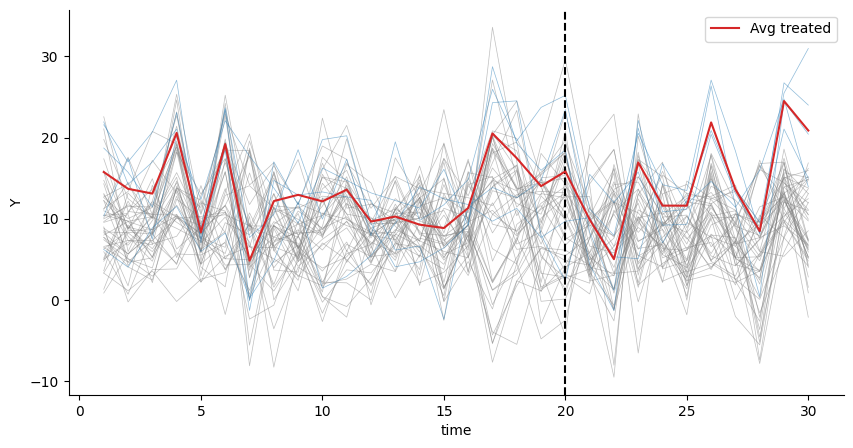

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

sns.lineplot(x='time', y='Y', data=data, hue='tr_group', units='id', estimator=None, alpha=0.5, palette=[color[7], color[0]], linewidth=0.5, legend=False, ax=ax)

ax.axvline(x=T0, color='black', linestyle='--')
ax.plot(data.query("tr_group==1").groupby('time').Y.mean(), color=color[3], label='Avg treated')
ax.legend()

sns.despine()

In [16]:
L=2
# prepare contorl data for estimation--Gamma, F
Y0 = np.array(data.query("tr_group==0").pivot(index='id', columns='time', values='Y'))
X0 = np.empty((N_co, T0+T1, L))
for t in range(T0+T1):
    X0[:, t, 0] = data.query(f"(tr_group==0) & (time=={t+1})").X1
    X0[:, t, 1] = data.query(f"(tr_group==0) & (time=={t+1})").X2


In [17]:
covariates = ['X1', 'X2']
def _prepare_matrices(df):
    """
    define a function to generate pivoted data
    """
    Y = df.pivot(index='id', columns='time', values='Y').values
    X = np.array([df.pivot(index='id', columns='time', values=x).values for x in covariates]).transpose(1, 2, 0)
    return Y, X

In [18]:
# K: number of factors
K = 1
# L: number of covariates
L = 2

# step 1: initial guess
svU, svS, svV = ssla.svds(Y0, K)
svU, svS, svV = np.fliplr(svU), svS[::-1], np.flipud(svV) # reverse order to match MATLAB svds output
# initial guess for factors
F0 = np.diag(svS) @ svV
gamma0 = np.random.normal(0, 1, size=(L, K))
lambda0 = np.random.normal(0, 1, size=(N_co, K))

max_iter, min_tol = 1000, 1e-6
iter, tol = 0, float('inf')
while (iter < max_iter) and (tol > min_tol):
    # update gamma
    vec_len = L*K
    numer, denom = np.zeros(vec_len), np.zeros((vec_len, vec_len))
    for t in range(T0+T1):
        ft_slice = F0[:, t] # Kx1 for each t
        for i in range(N_co):
            lambdai_slice = lambda0[i, :] # 1xK for each i
            x0_slice = X0[i, t, :] # Lx1 for each i
            # compute the kronecker product
            kron_prod = np.kron(x0_slice, ft_slice)
            # update the numerator and denominator
            numer += kron_prod * (Y0[i, t] - lambdai_slice @ ft_slice)
            denom += np.outer(kron_prod, kron_prod)
    # solve for gamma using the numerator and denominator
    gamma1 = _mldivide(denom, numer).reshape(L, K)
    # update the tolerance
    gamma_tol = abs(gamma1 - gamma0).max()
    gamma0 = gamma1

    # update lambda
    residual = np.zeros((N_co, T0+T1))
    for t in range(T0+T1):
        residual[:, t] = Y0[:, t] - X0[:, t, :]@gamma0@F0[:,t]
    M = residual.T@residual / N_co / (T0+T1)
    s, v, d = sla.svd(M)
    F_ = s[:, :K]
    lambda1 = residual @ F_ / (T0+T1)

    lambda_tol = abs(lambda1 - lambda0).max()
    lambda0 = lambda1

    # update F
    F1 = np.zeros((K, T0+T1))
    for t in range(T0+T1):
        sudo_x = X0[:,t,:]@gamma0 + lambda0
        denom = sudo_x.T@sudo_x
        numer = sudo_x.T@Y0[:,t]
        F1[:, t] = _mldivide(denom, numer)
    f_tol = abs(F1 - F0).max()
    F0 = F1 
    tol = max(gamma_tol, lambda_tol, f_tol)
    print(f'iter: {iter}, tol_gamma: {gamma_tol}, tol_lambda: {lambda_tol}, tol_F: {f_tol}')
    iter += 1

iter: 0, tol_gamma: 1.0069893966976147, tol_lambda: 2.715712916220228, tol_F: 113.60903824306159
iter: 1, tol_gamma: 0.2396463301892094, tol_lambda: 3.5154079839814325, tol_F: 29.770244733200897
iter: 2, tol_gamma: 0.3831926561263068, tol_lambda: 0.13027333952822429, tol_F: 2.3409651040032395
iter: 3, tol_gamma: 0.11850694495144515, tol_lambda: 0.32714148912922836, tol_F: 0.8233911537996836
iter: 4, tol_gamma: 0.059494775084097465, tol_lambda: 0.2303697227174053, tol_F: 0.4806539381341759
iter: 5, tol_gamma: 0.04262081349759142, tol_lambda: 0.15120937264741996, tol_F: 0.2414851964399789
iter: 6, tol_gamma: 0.0298894686742614, tol_lambda: 0.10054454812216784, tol_F: 0.17835291112618012
iter: 7, tol_gamma: 0.021686253774177433, tol_lambda: 0.0690019359922317, tol_F: 0.14096309129792672
iter: 8, tol_gamma: 0.017246747548226082, tol_lambda: 0.049029672806183644, tol_F: 0.11384353193883978
iter: 9, tol_gamma: 0.014021114396729484, tol_lambda: 0.03601789360663199, tol_F: 0.09327523109252933


In [19]:
# step 2: estimate factor loadings lambda_tr

Y10 = np.array(data.query(f"tr_group==1 & time<={T0}").pivot(index='id', columns='time', values='Y'))
X10 = np.empty((N_tr, T0, L))
for t in range(T0):
    X10[:, t, 0] = data.query(f"(tr_group==1) & (time=={t+1})").X1
    X10[:, t, 1] = data.query(f"(tr_group==1) & (time=={t+1})").X2

# update lambda
residual = np.zeros((N_tr, T0))
for t in range(T0):
    residual[:, t] = Y10[:, t] - X10[:, t, :]@gamma1@F1[:,t]
M = residual.T@residual / (N_tr*T0)
s, v, d = np.linalg.svd(M)
F_ = s[:, :K]
lambda10_1 = residual @ F_ / T0

In [9]:
# step 3: compute counterfactuals
Y1 = np.array(data.query("tr_group==1").pivot(index='id', columns='time', values='Y'))
X1 = np.empty((N_tr, T0+T1, L))
for t in range(T0+T1):
    X1[:, t, 0] = data.query(f"(tr_group==1) & (time=={t+1})").X1
    X1[:, t, 1] = data.query(f"(tr_group==1) & (time=={t+1})").X2

Y_syn = np.zeros((N_tr, T0+T1))
for t in range(T0+T1):
    for i in range(N_tr):
        Y_syn[i, t] = X1[i, t, :]@gamma1@F1[:,t] + lambda10_1[i, :]@F1[:,t]

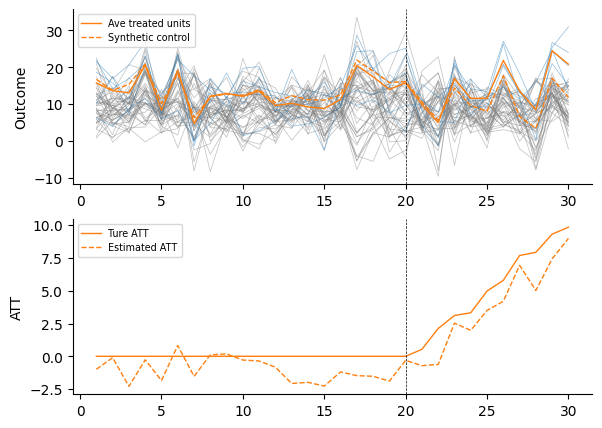

In [20]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6.7, 5))

# Plot for control and treatment groups
sns.lineplot(data=data, x='time', y='Y', hue='tr_group', estimator=None, units='id', palette=[color[7], color[0]], linewidth=0.5, alpha=0.5, ax=ax1, legend=False)

# Average for treated group and synthetic control
ave_treated = data.query("tr_group==1").groupby('time')['Y'].mean()
synthetic_control = pd.Series(Y_syn.mean(axis=0), index=ave_treated.index)

ave_treated.plot(ax=ax1, color=color[1], linestyle='-', linewidth=1, label='Ave treated units')
synthetic_control.plot(ax=ax1, color=color[1], linestyle='--', linewidth=1, label='Synthetic control')

# Add a vertical line for one year before treatment
ax1.axvline(data.query("post_period==0")['time'].max(), color='black', linestyle='--', linewidth=0.5)

# True ATT and Estimated ATT
true_att = data.query("tr_group==1").groupby('time')['eff'].mean()
estimated_att = data.query("tr_group==1").groupby('time')['Y'].mean() - synthetic_control.values

true_att.plot(ax=ax2, color=color[1], linestyle='-', linewidth=1, label='Ture ATT')
estimated_att.plot(ax=ax2, color=color[1], linestyle='--', linewidth=1, label='Estimated ATT')

# Add vertical line for one year before treatment and customize the second subplot
ax2.axvline(data.query("post_period==0")['time'].max(), color='black', linestyle='--', linewidth=0.5)
ax2.legend(loc='upper left', fontsize='x-small')
ax2.set(xlabel='', ylabel='ATT')

# Add legend and labels
ax1.legend(fontsize='x-small')
ax1.set(xlabel='', ylabel='Outcome')

sns.despine()